In [1]:
import os
import re
import numpy as np
import argparse
from sdk.build_pointcloud import build_pointcloud
from sdk.transform import build_se3_transform
from sdk.camera_model import CameraModel

In [32]:
models_dir = '/home/madhu/code/feature-slam/git_repos/dtd/robotcar-dataset-sdk/models'
images_dir = '/hdd1/madhu/data/robotcar/depth_test_splits/2014-12-16-18-44-24/stereo/left'
testfile_timestamps = '/home/madhu/code/feature-slam/git_repos/dtd/datasets/robotcar/2014-12-16-18-44-24_test.txt'
laser_dir = '/mnt/nas/madhu/data/robotcar/2014-12-16-18-44-24/lms_front'
extrinsics_dir = '/home/madhu/code/feature-slam/git_repos/dtd/robotcar-dataset-sdk/extrinsics'
poses_file = '/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/gps/ins.csv'
#poses_file = '/mnt/nas/madhu/awsgpu2/datasets/robotcar/2014-12-16-18-44-24/vo/vo.csv'

In [ ]:
model = CameraModel(models_dir, images_dir)
extrinsics_path = os.path.join(extrinsics_dir, "stereo" + ".txt")
with open(extrinsics_path) as extrinsics_file:
    extrinsics = [float(x) for x in next(extrinsics_file).split(" ")]
G_camera_vehicle = build_se3_transform(extrinsics)
with open(os.path.join(extrinsics_dir, "ins.txt")) as extrinsics_file:
    extrinsics = next(extrinsics_file)
    G_camera_posesource = G_camera_vehicle * build_se3_transform(
        [float(x) for x in extrinsics.split(" ")]
    )
print(G_camera_posesource)
timestamps = np.loadtxt(testfile_timestamps)
timestamps = timestamps[:, 0]


In [42]:
#[438 432 427 509 512 511 428 424 431]
test_index = 0

In [60]:
import tqdm
all_depths = []
for idx in tqdm.tqdm(range(len(timestamps)), total = len(timestamps)):
    timestamp = int(timestamps[test_index])
    im_shape = (960, 1280)
    pointcloud, reflectance = build_pointcloud(
        laser_dir,
        poses_file,
        extrinsics_dir,
        timestamp - 1e7,
        timestamp + 1e7,
        timestamp,
    )

    # breakpoint()
    pointcloud = np.dot(G_camera_posesource, pointcloud)
    velo_pts_im, velo_depth = model.project(pointcloud, im_shape)
    velo_pts_im = velo_pts_im.T

    velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1

    depth = np.zeros((im_shape[0], im_shape[1]))

    depth[
        velo_pts_im[:, 1].astype(np.int32), velo_pts_im[:, 0].astype(np.int32)
    ] = np.expand_dims(velo_depth, 1)

    depth[depth < 0] = 0
    crop_height = (im_shape[0] * 4) // 5
    depth = depth[:crop_height, :]

    all_depths.append(depth)


  1%|          | 7/716 [00:49<1:23:48,  7.09s/it]


KeyboardInterrupt: 

In [44]:
import cv2
image_path = os.path.join(images_dir, str(timestamp) + ".png")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:crop_height, :]


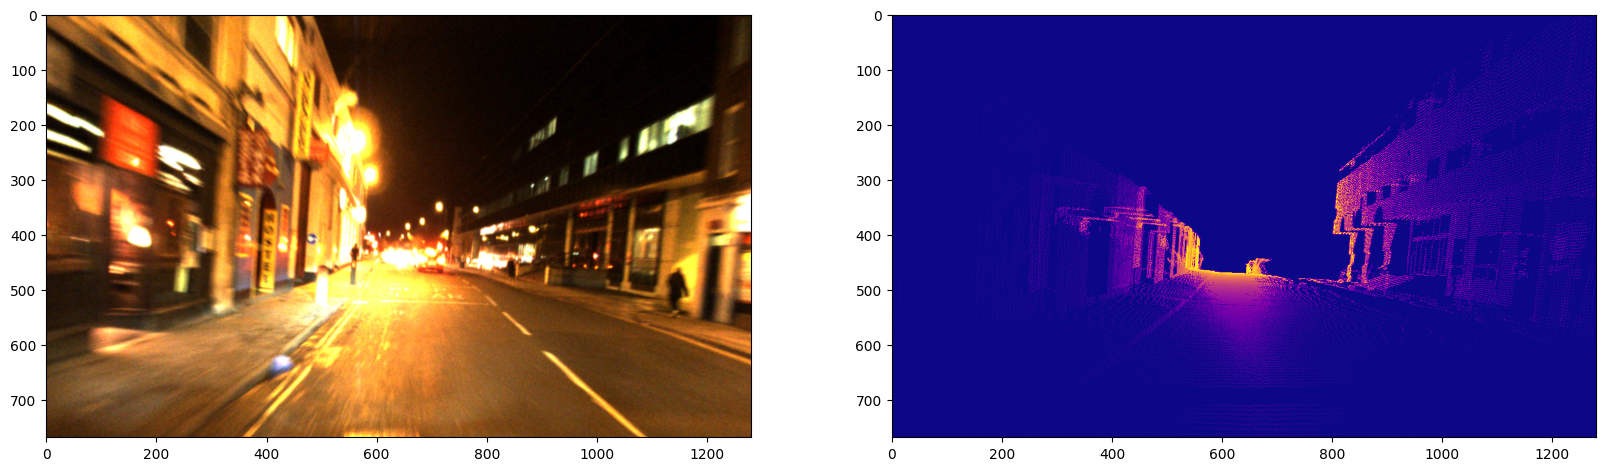

In [45]:
from matplotlib import pyplot as plt
ax, fig = plt.subplots(1, 2, figsize=(20, 10))
fig[0].imshow(image)
#crop_depth = np.where(depth > 50, 0, depth)
fig[1].imshow(depth,cmap='plasma')
plt.show()

In [55]:
#pred_disp_path = '/mnt/nas/madhu/data/predictions/chapter_4_cvpr/icra_2024.npy'
pred_disp_path = '/mnt/nas/madhu/data/predictions/chapter_4_cvpr/baseline_d_n_f16_warping_ddim.npy'
print("-> Loading predictions from ",pred_disp_path)
pred_disps = np.load(pred_disp_path)

-> Loading predictions from  /mnt/nas/madhu/data/predictions/chapter_4_cvpr/baseline_d_n_f16_warping_ddim.npy


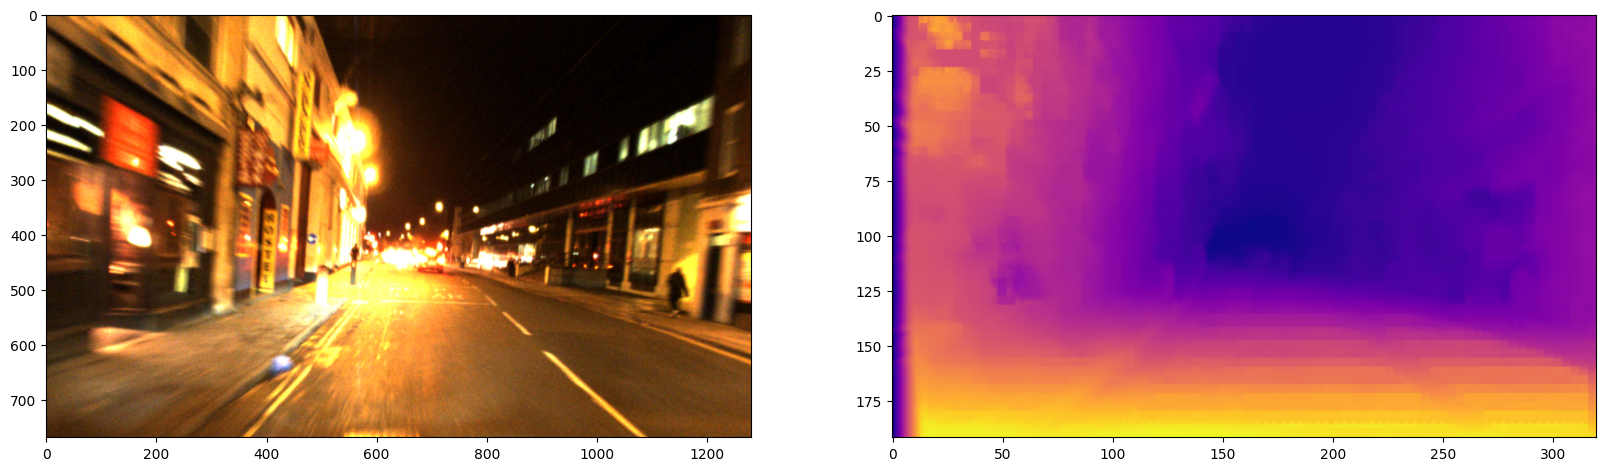

In [56]:
disp = pred_disps[test_index]
ax, fig = plt.subplots(1, 2, figsize=(20, 10))
fig[0].imshow(image)
fig[1].imshow(disp, cmap='plasma')
plt.show()

In [48]:
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [58]:
MIN_DEPTH = 1e-3
MAX_DEPTH = 50
ROBOTCAR_SCALE_FACTOR = 0.239983*100.
ROBOTCAR_SCALE_FACTOR = 0.2399 * 983.044006 * 0.25
disp = pred_disps[test_index]
disp = cv2.resize(disp, (depth.shape[1], depth.shape[0]))
pred_depth = ROBOTCAR_SCALE_FACTOR  /(disp + 1e-6)

mask = np.logical_and(depth > MIN_DEPTH, depth < MAX_DEPTH)
masked_gt = depth[mask]
masked_pred = pred_depth[mask]

print(max(masked_gt))
  

masked_pred[masked_pred < MIN_DEPTH] = MIN_DEPTH
masked_pred[masked_pred > MAX_DEPTH] = MAX_DEPTH


print("-> Evaluating")
errors = compute_errors(masked_gt, masked_pred)
print("   ", errors)
print("-> Done!")


49.9996437347613
-> Evaluating
    (0.11974426574431986, 1.099841762058606, 5.538429792120843, 0.20615847417271985, 0.8763177840556742, 0.9653758699097361, 0.9817749603803486)
-> Done!
